In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
! pip install lightgbm
! pip install xgboost
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'jpg'
%matplotlib inline

In [2]:
df =pd.read_csv('train.csv')
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
df.shape

(54808, 14)

In [3]:
df.rename(columns = {'is_promoted':'promotion'}, inplace = True)

In [5]:
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'promotion'],
      dtype='object')

In [6]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,promotion
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [3]:
df.age = df.age.astype(int)
df.age[df.age>55]= 55

In [4]:
df.length_of_service = df.length_of_service.astype(int)
df.length_of_service[df.length_of_service>25]= 25

In [5]:
df.education[df.education.isna()] = 'Diploma'
df.previous_year_rating[df.previous_year_rating.isna()] = df.previous_year_rating.median()

In [10]:
df.education.unique()

array(["Master's & above", "Bachelor's", 'Diploma', 'Below Secondary'],
      dtype=object)

In [6]:
df["education"].replace({"Below Secondary": "1.0", "Diploma": "2.0", "Bachelor's": "3.0", "Master's & above": "4.0"}, inplace=True)
df['education'] = pd.to_numeric(df['education'], errors='coerce')

In [20]:
df['gender'] = df.gender.map({'m': 'Male', 'f': 'Female'})

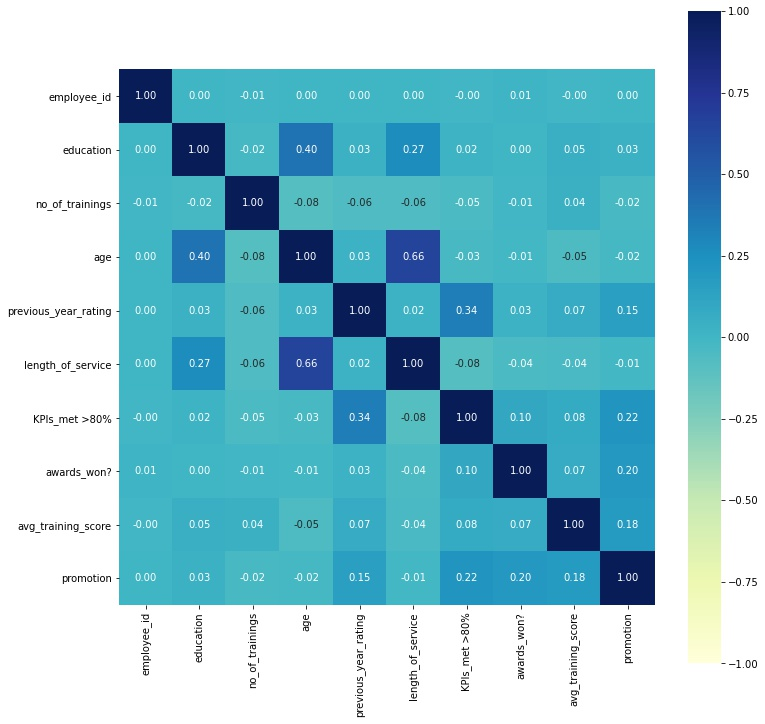

In [9]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), vmax = 1, vmin = -1, cmap = 'YlGnBu', cbar=True, annot=True, square=True, fmt='.2f', annot_kws = {'size': 10});

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

.

**Transformations**
1. Train-test split
2. Scale data
3. Deal with class imbalance



In [12]:
# Train-test split

x_train = df.loc[:,['education','no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?']]
y_train = df['promotion']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

In [13]:
## import StandardScaler
feature_scale=['education','no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?']
scaler=MinMaxScaler()
scaler.fit(x_train[feature_scale])
scaler.transform(x_train[feature_scale])
scaler.transform(x_test[feature_scale])

array([[0.66666667, 0.        , 0.42857143, ..., 0.375     , 0.        ,
        0.        ],
       [0.66666667, 0.22222222, 0.37142857, ..., 0.125     , 0.        ,
        0.        ],
       [0.66666667, 0.11111111, 0.51428571, ..., 0.41666667, 0.        ,
        0.        ],
       ...,
       [0.66666667, 0.11111111, 0.88571429, ..., 0.91666667, 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.28571429, ..., 0.08333333, 1.        ,
        0.        ],
       [0.66666667, 0.        , 0.37142857, ..., 0.29166667, 0.        ,
        0.        ]])

### **For Model 1**

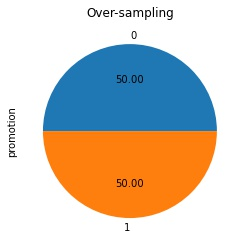

In [14]:
#Here for imbalanced data
ros = RandomOverSampler(sampling_strategy="not majority") 
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)
ax = y_train_ros.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

### **For Model 2**

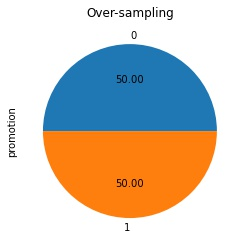

In [15]:
#Second model
x_train1 = df.loc[:,['previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?',]]
y_train1 = df['promotion']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train1, y_train1, test_size=0.33, random_state=42)
#Here for imbalanced data
ros1 = RandomOverSampler(sampling_strategy="not majority") 
x_train_ros1, y_train_ros1 = ros1.fit_resample(x_train1, y_train1)
ax1 = y_train_ros1.value_counts().plot.pie(autopct='%.2f')
_ = ax1.set_title("Over-sampling")

# **Logistic Regression**

### **Model 1**

In [74]:
#Logistic Regression algorithm for first model
lr = LogisticRegression().fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9169016420633604
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     16613
           1       0.43      0.06      0.10      1474

    accuracy                           0.92     18087
   macro avg       0.67      0.52      0.53     18087
weighted avg       0.88      0.92      0.89     18087



In [73]:
lr = LogisticRegression().fit(x_train_ros, y_train_ros)
y_pred = lr.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7070271465693592
              precision    recall  f1-score   support

           0       0.97      0.70      0.82     16613
           1       0.18      0.73      0.29      1474

    accuracy                           0.71     18087
   macro avg       0.57      0.72      0.55     18087
weighted avg       0.90      0.71      0.77     18087



In [75]:
scores = cross_val_score(lr, x_train_ros, y_train_ros, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.71667164 0.71846108 0.71875932 0.73456606 0.7052506  0.72076372
 0.70912888 0.70504026 0.70832091 0.70921563]
0.7146178092215356


### Grid Search

In [79]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(x_train_ros,y_train_ros)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("recall :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
recall : 0.7120527478480989


In [80]:
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(x_train_ros,y_train_ros)
print("score",logreg2.score(x_test,y_test))

score 0.7070271465693592


### **Model 2**

In [81]:
#Logistic Regression algorithm for second model
lr1 = LogisticRegression().fit(x_train1, y_train1)
y_pred1 = lr1.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

0.916404047105656
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     16613
           1       0.42      0.07      0.11      1474

    accuracy                           0.92     18087
   macro avg       0.67      0.53      0.54     18087
weighted avg       0.88      0.92      0.89     18087



In [82]:
lr1 = LogisticRegression().fit(x_train_ros1, y_train_ros1)
y_pred1 = lr1.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

0.705810803339415
              precision    recall  f1-score   support

           0       0.97      0.70      0.81     16613
           1       0.18      0.73      0.29      1474

    accuracy                           0.71     18087
   macro avg       0.57      0.71      0.55     18087
weighted avg       0.90      0.71      0.77     18087



In [83]:
scores1 = cross_val_score(lr1, x_train_ros1, y_train_ros1, cv=10, scoring='recall')
print(scores1)
print(scores1.mean())

[0.71339099 0.70891739 0.70921563 0.720847   0.71420048 0.71897375
 0.71778043 0.72054876 0.71458395 0.71309275]
0.7151551134701443


### Grid Search

In [84]:
grid1={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg1=LogisticRegression()
logreg_cv1=GridSearchCV(logreg,grid,cv=10)
logreg_cv1.fit(x_train_ros1,y_train_ros1)

print("tuned hpyerparameters :(best parameters) ",logreg_cv1.best_params_)
print("recall :",logreg_cv1.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
recall : 0.7082351086086496


# **Random Forest**

### **Model 1**

In [14]:
#Random Forest algorithm for first model
rf = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=-1,random_state=42, max_features=None, min_samples_leaf=30).fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9206059600818267
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.69      0.05      0.09      1474

    accuracy                           0.92     18087
   macro avg       0.81      0.52      0.52     18087
weighted avg       0.90      0.92      0.89     18087



In [15]:
rf = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=-1,random_state=42, max_features=None, min_samples_leaf=30).fit(x_test_ros, y_test_ros)
y_pred = rf.predict(x_test_ros)
print(metrics.accuracy_score(y_test_ros, y_pred))
print(classification_report(y_test_ros, y_pred))

0.7741226750135436
              precision    recall  f1-score   support

           0       0.82      0.70      0.76     16613
           1       0.74      0.85      0.79     16613

    accuracy                           0.77     33226
   macro avg       0.78      0.77      0.77     33226
weighted avg       0.78      0.77      0.77     33226



In [16]:
scores = cross_val_score(rf, x_test_ros, y_test_ros, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.83925346 0.82420229 0.82962071 0.8423586  0.83935018 0.83273165
 0.83744732 0.83022276 0.83804937 0.84467188]
0.8357908223700653


### Grid Search

In [25]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features=None,
                                              min_samples_leaf=30,
                                              n_estimators=70, n_jobs=-1,
                                              oob_score=True, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [21]:
CV_rfc.best_params_
CV_rfc.best_score_

NameError: name 'CV_rfc' is not defined

In [27]:
# تعديل الباراميتار حسب الريد سيرش
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [28]:
rfc1.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [34]:
pred=rfc1.predict(x_test_ros)

In [105]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_train_ros,pred))

NameError: name 'pred' is not defined

### **Model 2**

In [67]:
#Random Forest algorithm for second model
rf1 = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=-1,random_state=42, max_features=None, min_samples_leaf=30).fit(x_train1, y_train1)
y_pred1 = rf1.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

0.9206059600818267
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.66      0.05      0.10      1474

    accuracy                           0.92     18087
   macro avg       0.79      0.53      0.53     18087
weighted avg       0.90      0.92      0.89     18087



In [76]:
rf1 = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=-1,random_state=42, max_features=None, min_samples_leaf=30).fit(x_test_ros1, y_test_ros1)
y_pred1 = rf1.predict(x_test_ros1)
print(metrics.accuracy_score(y_test_ros1, y_pred1))
print(classification_report(y_test_ros1, y_pred1))

0.7358694997893216
              precision    recall  f1-score   support

           0       0.80      0.64      0.71     16613
           1       0.70      0.84      0.76     16613

    accuracy                           0.74     33226
   macro avg       0.75      0.74      0.73     33226
weighted avg       0.75      0.74      0.73     33226



In [70]:
scores1 = cross_val_score(rf1, x_test_ros1, y_test_ros1, cv=10, scoring='recall')
print(scores1)
print(scores1.mean())

[0.84948826 0.85009031 0.82600843 0.84596871 0.83754513 0.85078219
 0.83865141 0.83142685 0.83383504 0.83323299]
0.8397029322077737


### Grid Search

In [ ]:
param_grid_rf1 = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc1 = GridSearchCV(estimator=rf1, param_grid=param_grid_rf1rf1, cv= 3)
CV_rfc1.fit(x_train, y_train)

In [ ]:
CV_rfc1.best_params_

In [ ]:
# تعديل الباراميتار حسب الريد سيرش
rfc11=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [ ]:
rfc11.fit(x_train, y_train)

In [ ]:
pred1=rfc11.predict(x_test_ros)

In [ ]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_train,pred1))

.

# **ٍSVM**

### **Model 1**

In [86]:
#SVM algorithm for first model
svm = SVC(kernel='linear', C=0.025, random_state= 42).fit(x_train, y_train)
y_pred = svm.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9185050035937413
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.00      0.00      0.00      1474

    accuracy                           0.92     18087
   macro avg       0.46      0.50      0.48     18087
weighted avg       0.84      0.92      0.88     18087



In [96]:
svm = SVC(kernel='linear', C=0.025, random_state= 42).fit(x_train_ros, y_train_ros)
y_pred = svm.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.685243545087632
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     16613
           1       0.17      0.76      0.28      1474

    accuracy                           0.69     18087
   macro avg       0.57      0.72      0.54     18087
weighted avg       0.90      0.69      0.76     18087



In [97]:
scores = cross_val_score(svm, x_train_ros, y_train_ros, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.74470623 0.74261855 0.74560095 0.75424993 0.73568019 0.74880668
 0.73955847 0.73814494 0.73575902 0.73277662]
0.7417901594198051


### Grid Search

In [99]:
# defining parameter range

parameters = [{'C': [1,10], 'kernel': ['linear']}]
 
grid_svm = GridSearchCV(SVC(), parameters, refit = True, verbose = 2)
 
# fitting the model for grid search
grid_svm.fit(x_train_ros, y_train_ros)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=1, kernel=linear, total=  48.5s
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.4s remaining:    0.0s


[CV] ............................... C=1, kernel=linear, total=  48.2s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  50.8s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  48.9s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  45.9s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total= 4.1min
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total= 4.1min
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total= 4.0min
[CV] C=10, kernel=linear .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 24.3min finished


GridSearchCV(estimator=SVC(), param_grid=[{'C': [1, 10], 'kernel': ['linear']}],
             verbose=2)

In [106]:
# print best parameter after tuning
print(grid_svm.best_params_)
print(grid_svm.best_score_) 
# print how our model looks after hyper-parameter tuning
print(grid_svm.best_estimator_)

{'C': 1, 'kernel': 'linear'}
0.7084886331303601
SVC(C=1, kernel='linear')


In [102]:
grid_predictions = grid_svm.predict(x_train_ros)
 
# print classification report
print(classification_report(y_tarin_ros, grid_predictions))

NameError: name 'y_tarin_ros' is not defined

### **Model 2**

In [71]:
#SVM algorithm for second model
svm1 = SVC(kernel='linear', C=0.025, random_state= 42).fit(x_train1, y_train1)
y_pred1 = svm1.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

0.9185050035937413
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.00      0.00      0.00      1474

    accuracy                           0.92     18087
   macro avg       0.46      0.50      0.48     18087
weighted avg       0.84      0.92      0.88     18087



In [72]:
svm1 = SVC(kernel='linear', C=0.025, random_state= 42).fit(x_test_ros1, y_test_ros1)
y_pred1 = svm1.predict(x_test_ros1)
print(metrics.accuracy_score(y_test_ros1, y_pred1))
print(classification_report(y_test_ros1, y_pred1))

0.7168783482814663
              precision    recall  f1-score   support

           0       0.73      0.68      0.71     16613
           1       0.70      0.76      0.73     16613

    accuracy                           0.72     33226
   macro avg       0.72      0.72      0.72     33226
weighted avg       0.72      0.72      0.72     33226



In [73]:
scores1 = cross_val_score(svm1, x_test_ros1, y_test_ros1, cv=10, scoring='recall')
print(scores1)
print(scores1.mean())

[0.76038531 0.75978326 0.75316075 0.75812274 0.73886883 0.76955475
 0.743528   0.75135461 0.75436484 0.76339554]
0.7552518635563079


# **KNN**

### **Model 1**

In [94]:
#Knn algorithm for first model
#knn = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)
#y_pred = knn.predict(x_test)
#print(metrics.accuracy_score(y_train, y_pred))
#print(classification_report(y_train, y_pred))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_ros, y_train_ros)
y_pred = knn.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7387073588765412
              precision    recall  f1-score   support

           0       0.94      0.76      0.84     16613
           1       0.15      0.47      0.23      1474

    accuracy                           0.74     18087
   macro avg       0.55      0.62      0.54     18087
weighted avg       0.88      0.74      0.79     18087



In [33]:
knn = KNeighborsClassifier(n_neighbors=5).fit(x_test_ros, y_test_ros)
y_pred = knn.predict(x_test_ros)
print(metrics.accuracy_score(y_test_ros, y_pred))
print(classification_report(y_test_ros, y_pred))

lbg = LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42).fit(x_train_ros, y_train_ros)
y_pred = lbg.predict(x_train_ros)
print(metrics.accuracy_score(y_train_ros, y_pred))
print(classification_report(y_train_ros, y_pred))

0.8460542948293505
              precision    recall  f1-score   support

           0       0.90      0.78      0.83     16613
           1       0.81      0.91      0.86     16613

    accuracy                           0.85     33226
   macro avg       0.85      0.85      0.85     33226
weighted avg       0.85      0.85      0.85     33226



In [34]:
scores = cross_val_score(knn, x_test_ros, y_test_ros, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.89343769 0.91450933 0.90547863 0.87845969 0.91215403 0.89951865
 0.90066225 0.91932571 0.91812161 0.89283564]
0.9034503231564939


### Grid Search

In [29]:
k_range = list(range(1, 15))
weight_options = ['uniform', 'distance']

In [30]:
param_grid = dict(n_neighbors=k_range , weights=weight_options)

In [37]:
grid = GridSearchCV(knn, param_grid, n_jobs= -1, cv=7, scoring='recall')

In [38]:
grid.fit(x_test_ros, y_test_ros);

In [39]:
grid.cv_results_

{'mean_fit_time': array([0.88360613, 1.09707652, 0.75335857, 0.92658704, 0.81441021,
        0.85599525, 0.88237071, 0.94475951, 0.93293408, 0.95929224,
        0.94764706, 0.93337727, 0.96007667, 0.92436351, 0.81795532,
        1.15877158, 0.8141645 , 1.1254783 , 0.8150192 , 1.16833704,
        0.90624172, 1.12130424, 0.8957477 , 1.08474391, 0.89820194,
        1.05462016, 0.83675296, 1.14631762]),
 'std_fit_time': array([0.18372029, 0.35521261, 0.03467759, 0.12518398, 0.10954826,
        0.13147115, 0.19854519, 0.25247585, 0.26237412, 0.29170212,
        0.2348241 , 0.25543548, 0.24840376, 0.21716119, 0.21258334,
        0.27990047, 0.17116607, 0.25575384, 0.14670256, 0.28705156,
        0.29435965, 0.26483799, 0.26308504, 0.32906385, 0.28458921,
        0.27850728, 0.26837056, 0.25808961]),
 'mean_score_time': array([1.69935448, 0.59414332, 1.38149033, 0.67312193, 1.57420114,
        0.6817877 , 1.81484086, 0.74716966, 1.64988327, 0.76053814,
        1.87658933, 0.83733249, 1.904264

In [40]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'n_neighbors': 13, 'weights': 'distance'}
Best estimator:  KNeighborsClassifier(n_neighbors=13, weights='distance')
Best score:  0.9343885409618589


In [44]:
knn = KNeighborsClassifier(n_neighbors=13, weights='distance')
knn.fit(x_test_ros, y_test_ros)
# knn.predict([[3, 5, 4, 2]]) error

KNeighborsClassifier(n_neighbors=13, weights='distance')

### **Model 2**

In [48]:
#Knn algorithm for second model
knn1 = KNeighborsClassifier(n_neighbors=5).fit(x_train1, y_train1)
y_pred1 = knn1.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

0.8960579421684083
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     16613
           1       0.22      0.11      0.15      1474

    accuracy                           0.90     18087
   macro avg       0.57      0.54      0.55     18087
weighted avg       0.87      0.90      0.88     18087



In [49]:
knn1 = KNeighborsClassifier(n_neighbors=5).fit(x_test_ros1, y_test_ros1)
y_pred1 = knn1.predict(x_test_ros1)
print(metrics.accuracy_score(y_test_ros1, y_pred1))
print(classification_report(y_test_ros1, y_pred1))

0.6639077830614579
              precision    recall  f1-score   support

           0       0.66      0.68      0.67     16613
           1       0.67      0.65      0.66     16613

    accuracy                           0.66     33226
   macro avg       0.66      0.66      0.66     33226
weighted avg       0.66      0.66      0.66     33226



In [50]:
scores1 = cross_val_score(knn1, x_test_ros1, y_test_ros1, cv=10, scoring='recall')
print(scores1)
print(scores1.mean())

[0.75376279 0.68031306 0.66646598 0.59687124 0.70818291 0.6576414
 0.63997592 0.5743528  0.56170981 0.61047562]
0.6449751537900341


### Grid Search

In [51]:
k_range1 = list(range(1, 15))
weight_options1 = ['uniform', 'distance']

param_grid1 = dict(n_neighbors=k_range1 , weights=weight_options1)

grid1 = GridSearchCV(knn1, param_grid1, n_jobs= -1, cv=7, scoring='recall')

grid1.fit(x_test_ros1, y_test_ros1);

grid1.cv_results_

{'mean_fit_time': array([1.3992453 , 1.30641341, 1.2531006 , 1.17178004, 1.13832222,
        1.17090171, 1.21817705, 1.14265847, 1.14764244, 1.07623121,
        1.25292393, 1.19955025, 1.21581803, 1.22534323, 1.3087006 ,
        1.12017066, 1.20084769, 1.2276253 , 1.25185238, 1.05644441,
        1.22926525, 1.12749764, 1.29243261, 1.10296185, 1.23408256,
        1.24148314, 1.26028793, 1.17549116]),
 'std_fit_time': array([0.30327024, 0.38127996, 0.23611087, 0.22925871, 0.1754166 ,
        0.18329941, 0.1822982 , 0.17698385, 0.22288491, 0.14125016,
        0.2655287 , 0.23649594, 0.23145528, 0.23153956, 0.17185764,
        0.25737552, 0.20350639, 0.21631084, 0.24150491, 0.18237574,
        0.19415431, 0.22424308, 0.18190215, 0.25403601, 0.29538762,
        0.18712704, 0.19432255, 0.21383214]),
 'mean_score_time': array([1.78939315, 0.66276302, 1.85682913, 0.66087076, 1.77915205,
        0.70400248, 1.80335368, 0.64989035, 1.84954235, 0.76652241,
        1.92080879, 0.75964107, 1.860108

In [52]:
print("Best params: ", grid1.best_params_)
print("Best estimator: ", grid1.best_estimator_)
print("Best score: ", grid1.best_score_)

Best params:  {'n_neighbors': 13, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=13)
Best score:  0.6968108190708272


In [53]:
knn1 = KNeighborsClassifier(n_neighbors=13, weights='distance')
knn1.fit(x_test_ros1, y_test_ros1) 
# knn1.predict([[3, 5, 4, 2]]) error

KNeighborsClassifier(n_neighbors=13, weights='distance')

# **LightGBM**

### **Model 1**

In [90]:
#LightGBM algorithm for first model
lbg = LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42).fit(x_train, y_train)
y_pred = lbg.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9198319234809532
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.59      0.05      0.10      1474

    accuracy                           0.92     18087
   macro avg       0.76      0.52      0.53     18087
weighted avg       0.90      0.92      0.89     18087



In [24]:
lbg = LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42).fit(x_train_ros, y_train_ros)
y_pred = lbg.predict(x_train_ros)
print(metrics.accuracy_score(y_train_ros, y_pred))
print(classification_report(y_train_ros, y_pred))

0.7561219315775345
              precision    recall  f1-score   support

           0       0.82      0.66      0.73     33527
           1       0.72      0.85      0.78     33527

    accuracy                           0.76     67054
   macro avg       0.77      0.76      0.75     67054
weighted avg       0.77      0.76      0.75     67054



In [25]:
scores = cross_val_score(lbg, x_train_ros, y_train_ros, cv=3, scoring='recall')
print(scores)
print(scores.mean())

[0.84645669 0.84697987 0.84878311]
0.8474065551141067


In [26]:
LGBM_range = list(range(1, 15))
weight_options3 = ['uniform', 'distance']

param_grid3 = dict(n_neighbors=LGBM_range , weights=weight_options3)

grid3 = GridSearchCV(lbg, param_grid3, n_jobs= -1, cv=7, scoring='recall')

grid3.fit(x_train_ros, y_train_ros);

grid3.cv_results_

[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights


{'mean_fit_time': array([2.66658112, 2.74918723, 2.84678483, 2.82668757, 2.7408561 ,
        2.76028449, 2.74004708, 2.86612562, 2.70558132, 2.95893618,
        2.957762  , 2.77894146, 2.85740743, 2.73637451, 3.0049837 ,
        2.91539591, 2.72776747, 2.93415536, 3.05921442, 2.97650504,
        2.70259343, 3.02403556, 2.88828816, 3.01444898, 2.66804518,
        2.59566573, 2.86700048, 2.65842182]),
 'std_fit_time': array([0.3418527 , 0.32058104, 0.46756894, 0.47168769, 0.34698513,
        0.39681954, 0.36517228, 0.33736986, 0.40137389, 0.52608829,
        0.4414932 , 0.42944056, 0.42615393, 0.47747682, 0.54391011,
        0.46024088, 0.48294599, 0.28616951, 0.56384752, 0.62077072,
        0.50036459, 0.53441484, 0.36817945, 0.47710035, 0.23024525,
        0.08133216, 0.18541299, 0.10717091]),
 'mean_score_time': array([0.4082582 , 0.42799483, 0.39626901, 0.39217036, 0.37017093,
        0.38513061, 0.36784032, 0.40616921, 0.37400661, 0.44585763,
        0.40849274, 0.37433246, 0.410282

In [27]:
print("Best params: ", grid3.best_params_)
print("Best estimator: ", grid3.best_estimator_)
print("Best score: ", grid3.best_score_)

Best params:  {'n_neighbors': 1, 'weights': 'uniform'}
Best estimator:  LGBMClassifier(learning_rate=0.09, max_depth=-5, n_neighbors=1, random_state=42,
               weights='uniform')
Best score:  0.8487190018232582


### **Model 2**

In [82]:
#LightGBM algorithm for second model
lbg1 = LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42).fit(x_train1, y_train1)
y_pred1 = lbg1.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

0.9207165367390944
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.67      0.05      0.10      1474

    accuracy                           0.92     18087
   macro avg       0.79      0.53      0.53     18087
weighted avg       0.90      0.92      0.89     18087



In [83]:
lbg1 = LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42).fit(x_test_ros1, y_test_ros1)
y_pred1 = lbg1.predict(x_test_ros1)
print(metrics.accuracy_score(y_test_ros1, y_pred1))
print(classification_report(y_test_ros1, y_pred1))

0.739541323060254
              precision    recall  f1-score   support

           0       0.81      0.63      0.71     16613
           1       0.70      0.85      0.77     16613

    accuracy                           0.74     33226
   macro avg       0.75      0.74      0.74     33226
weighted avg       0.75      0.74      0.74     33226



In [84]:
scores1 = cross_val_score(lbg1, x_test_ros1, y_test_ros1, cv=10, scoring='recall')
print(scores1)
print(scores1.mean())

[0.85490668 0.85430464 0.83865141 0.84957882 0.84115523 0.86040915
 0.84828417 0.8410596  0.84888621 0.84406984]
0.8481305753641806


# **XGBoost**

### **Model 1**

In [29]:
#XGBoost algorithm for first model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss').fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9188367335655443
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.52      0.06      0.10      1474

    accuracy                           0.92     18087
   macro avg       0.72      0.53      0.53     18087
weighted avg       0.89      0.92      0.89     18087



In [31]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss').fit(x_train_ros, y_train_ros)
y_pred = xgb.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6899983413501409
              precision    recall  f1-score   support

           0       0.97      0.69      0.80     16613
           1       0.17      0.74      0.28      1474

    accuracy                           0.69     18087
   macro avg       0.57      0.71      0.54     18087
weighted avg       0.90      0.69      0.76     18087



In [32]:
scores = cross_val_score(xgb, x_train_ros, y_train_ros, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.85863406 0.86161646 0.85237101 0.86221294 0.84337709 0.86157518
 0.86426014 0.85773934 0.86340591 0.85923054]
0.8584422669970324


### Grid Search

In [39]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [40]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [41]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3,
    verbose=True
)

In [42]:
grid_search.fit(x_train_ros, y_train_ros)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  9.2min
[Parallel(n_jobs=10)]: Done 288 out of 288 | elapsed: 15.1min finished


[21:46:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale

In [46]:
print("Best params: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)
print("Best score: ", grid_search.best_score_)

Best params:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}
Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
Best score:  0.8671880575352153


### **Model 2**

In [47]:
#XGBoost algorithm for second model
xgb1 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss').fit(x_train1, y_train1)
y_pred1 = xgb1.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

0.9206612484104606
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.65      0.06      0.11      1474

    accuracy                           0.92     18087
   macro avg       0.78      0.53      0.53     18087
weighted avg       0.90      0.92      0.89     18087



In [49]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss').fit(x_train_ros1, y_train_ros1)
y_pred = xgb.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred))
print(classification_report(y_test1, y_pred))

0.6485320948747719
              precision    recall  f1-score   support

           0       0.98      0.63      0.77     16613
           1       0.17      0.84      0.28      1474

    accuracy                           0.65     18087
   macro avg       0.57      0.73      0.52     18087
weighted avg       0.91      0.65      0.73     18087



In [51]:
scores1 = cross_val_score(xgb, x_train_ros1, y_train_ros1, cv=10, scoring='recall')
print(scores1)
print(scores1.mean())

[0.84252908 0.83417835 0.84223084 0.85356397 0.84188544 0.84785203
 0.84785203 0.85356397 0.84431852 0.83835371]
0.8446327941991891


### Grid Search

In [52]:
estimator1 = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [53]:
parameters1 = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [54]:
grid_search1 = GridSearchCV(
    estimator=estimator1,
    param_grid=parameters1,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3,
    verbose=True
)

In [55]:
grid_search1.fit(x_train_ros1, y_train_ros1)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   53.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  7.5min
[Parallel(n_jobs=10)]: Done 288 out of 288 | elapsed: 11.9min finished


[22:28:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale

In [57]:
print("Best params: ", grid_search1.best_params_)
print("Best estimator: ", grid_search1.best_estimator_)
print("Best score: ", grid_search1.best_score_)

Best params:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 180}
Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
Best score:  0.7877733844383964


# **Decision Tree**

### **Model 1**

In [58]:
#Decision Tree Regressor algorithm for first model
dtree = DecisionTreeClassifier(max_depth=10, random_state=42, max_features=None, min_samples_leaf=15).fit(x_train, y_train)
y_pred = dtree.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.919223751865981
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.55      0.05      0.09      1474

    accuracy                           0.92     18087
   macro avg       0.73      0.52      0.53     18087
weighted avg       0.89      0.92      0.89     18087



In [59]:
dtree = DecisionTreeClassifier(max_depth=10, random_state=42, max_features=None, min_samples_leaf=15).fit(x_train_ros, y_train_ros)
y_pred = dtree.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6674407032675402
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     16613
           1       0.17      0.80      0.28      1474

    accuracy                           0.67     18087
   macro avg       0.57      0.73      0.53     18087
weighted avg       0.91      0.67      0.74     18087



In [61]:
scores = cross_val_score(dtree, x_train_ros, y_train_ros, cv=10, scoring='recall')
print(scores)
print(scores.mean())

[0.82165225 0.82582762 0.83596779 0.84014316 0.81235084 0.83144391
 0.83502387 0.83417835 0.8279153  0.82702058]
0.8291523656014241


### Grid Search

In [66]:
params = {'max_leaf_nodes': list(range(2, 50)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(x_train_ros, y_train_ros)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   12.8s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [67]:
print("Best params: ", grid_search_cv.best_params_)
print("Best estimator: ", grid_search_cv.best_estimator_)
print("Best score: ", grid_search_cv.best_score_)

Best params:  {'max_leaf_nodes': 48, 'min_samples_split': 2}
Best estimator:  DecisionTreeClassifier(max_leaf_nodes=48, random_state=42)
Best score:  0.7344826345234163


### **Model 2**

In [68]:
#Decision Tree Regressor algorithm for second model
dtree1 = DecisionTreeClassifier(max_depth=10, random_state=42, max_features=None, min_samples_leaf=15).fit(x_train1, y_train1)
y_pred1 = dtree1.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

0.9208824017249958
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16613
           1       0.72      0.05      0.09      1474

    accuracy                           0.92     18087
   macro avg       0.82      0.52      0.52     18087
weighted avg       0.91      0.92      0.89     18087



In [69]:
dtree1 = DecisionTreeClassifier(max_depth=10, random_state=42, max_features=None, min_samples_leaf=15).fit(x_train_ros1, y_train_ros1)
y_pred1 = dtree1.predict(x_test1)
print(metrics.accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

0.6485873832034058
              precision    recall  f1-score   support

           0       0.98      0.63      0.77     16613
           1       0.17      0.84      0.28      1474

    accuracy                           0.65     18087
   macro avg       0.57      0.73      0.52     18087
weighted avg       0.91      0.65      0.73     18087



In [70]:
scores1 = cross_val_score(dtree1, x_train_ros1, y_train_ros1, cv=10, scoring='recall')
print(scores1)
print(scores1.mean())

[0.84014316 0.83537131 0.84103788 0.84938861 0.8374105  0.84665871
 0.84576372 0.84700268 0.84103788 0.83477483]
0.8418589273168973


### Grid Search

In [71]:
params1 = {'max_leaf_nodes': list(range(2, 50)), 'min_samples_split': [2, 3, 4]}
grid_search_cv1 = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv1.fit(x_train_ros1, y_train_ros1)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:    8.2s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [72]:
print("Best params: ", grid_search_cv1.best_params_)
print("Best estimator: ", grid_search_cv1.best_estimator_)
print("Best score: ", grid_search_cv1.best_score_)

Best params:  {'max_leaf_nodes': 49, 'min_samples_split': 2}
Best estimator:  DecisionTreeClassifier(max_leaf_nodes=49, random_state=42)
Best score:  0.7358546694880975


.

.

In [101]:
! pip install pycaret

  Using cached pycaret-2.3.5-py3-none-any.whl (288 kB)
  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl (261 kB)
  Using cached mlflow-1.22.0-py3-none-any.whl (15.5 MB)
  Using cached pyod-0.9.5-py3-none-any.whl
  Using cached gensim-3.8.3-cp38-cp38-win_amd64.whl (24.2 MB)
  Using cached mlxtend-0.19.0-py2.py3-none-any.whl (1.3 MB)
  Using cached spacy-2.3.7-cp38-cp38-win_amd64.whl (9.7 MB)
  Using cached wordcloud-1.8.1-cp38-cp38-win_amd64.whl (155 kB)
  Using cached cufflinks-0.17.3-py3-none-any.whl
  Using cached umap_learn-0.5.2-py3-none-any.whl
  Using cached scikit_learn-0.23.2-cp38-cp38-win_amd64.whl (6.8 MB)
  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)
  Using cached imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)
  Using cached plotly-5.4.0-py2.py3-none-any.whl (25.3 MB)
  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build 

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\amora\\anaconda3\\Lib\\site-packages\\~klearn\\cluster\\_dbscan_inner.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [102]:
diabetes = get_data('diabetes')
# Importing module and initializing setup
from pycaret.classification import *
clf1 = setup(data = df, target = 'promotion')
# create individual models for stacking
xgb1 = create_model('xgb1')
Ir1 = create_model('Ir1')
rf1 = create_model('rf1')
svm1 = create_model('svm1')
# stacking models
stacker = stack_models(estimator_list = [xgb1,Ir1,rf1,svm1], meta_model = xgboost)
# stack models dynamically
top5 = compare_models(n_select = 4)
stacker = stack_models(estimator_list = top5[1:], meta_model = top5[0])

NameError: name 'get_data' is not defined